在 回归 (regression) 问题中，我们的目的是预测出如价格或概率这样连续值的输出。相对于分类(classification) 问题，分类(classification) 的目的是从一系列的分类出选择出一个分类 （如，给出一张包含苹果或橘子的图片，识别出图片中是哪种水果）。

本 notebook 使用经典的 [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) 数据集，构建了一个用来预测70年代末到80年代初汽车燃油效率的模型。为了做到这一点，我们将为该模型提供许多那个时期的汽车描述。这个描述包含：气缸数，排量，马力以及重量。

本示例使用 `tf.keras API`，相关细节请参阅 [本指南](https://tensorflow.google.cn/guide/keras)。

In [35]:
# 使用 seaborn 绘制矩阵图 (pairplot)
# pip install -q seaborn
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.7.0


# Auto MPG 数据集
该数据集可以从 [UCI机器学习库](https://archive.ics.uci.edu/ml/) 中获取.

## 获取数据
首先下载数据集。格式如下:

```csv
18.0   8   307.0      130.0      3504.      12.0   70  1	"chevrolet chevelle malibu"
15.0   8   350.0      165.0      3693.      11.5   70  1	"buick skylark 320"
18.0   8   318.0      150.0      3436.      11.0   70  1	"plymouth satellite"
...
```

In [36]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'/root/.keras/datasets/auto-mpg.data'

使用 pandas 导入数据集。

In [37]:
# 设置列名
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
# 读取 csv 文件，空值为 "?", 分隔符为 " ", tab 表示注释，会被忽略，跳过初始空格
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


## 数据清洗
数据集中包括一些未知值。`汇总各个包含空值的字段`

In [38]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

为了保证这个初始示例的简单性，`删除这些包含空值的行`。

In [39]:
dataset = dataset.dropna()

`"Origin"` 列实际上代表分类，而不仅仅是一个数字。所以把它`转换为独热码 （one-hot）`

In [40]:
origin = dataset.pop('Origin')

再根据 Origin 拆分为 USA、Europe 和 Japan 三个区域

In [9]:
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


## 拆分训练数据集和测试数据集
现在需要将数据集拆分为一个训练数据集和一个测试数据集。

我们最后将使用测试数据集对模型进行评估。

In [10]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

## 数据检查
快速查看训练集中几对列的联合分布。

In [11]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

![图片不现实的话后面会计算出来](https://www.tensorflow.org/tutorials/keras/regression_files/output_oRKO_x8gWKv-_1.png)

也可以查看总体的数据统计:

In [12]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


## 从标签中分离特征
将特征值从目标值或者"标签"中分离。 这个标签是你使用训练模型进行预测的值。

In [14]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

## 数据规范化
再次审视下上面的 `train_stats` 部分，并注意每个特征的范围有什么不同。

使用不同的尺度和范围对特征归一化是好的实践。尽管模型可能 在没有特征归一化的情况下收敛，它会使得模型训练更加复杂，并会造成生成的模型依赖输入所使用的单位选择。

注意：尽管我们仅仅从训练集中有意生成这些统计数据，但是这些统计信息也会用于归一化的测试数据集。我们需要这样做，将测试数据集放入到与已经训练过的模型相同的分布中。

In [15]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

我们将会使用这个已经归一化的数据来训练模型。

警告: 用于归一化输入的数据统计（均值和标准差）需要反馈给模型从而应用于任何其他数据，以及我们之前所获得独热码。这些数据包含测试数据集以及生产环境中所使用的实时数据。

# 模型
## 构建模型
让我们来构建我们自己的模型。

这里，我们将会使用一个**“顺序”**模型，其中包含:

- 两个紧密相连的隐藏层
- 以及返回单个、连续值得输出层

模型的构建步骤包含于一个名叫 `'build_model'` 的函数中，稍后我们将会创建第二个模型。 两个密集连接的隐藏层。

In [17]:
def build_model():
  # 顺序模型
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [18]:
model = build_model()

## 检查模型
使用 `.summary` 方法来打印该模型的简单描述。

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                640       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


现在试用下这个模型。从训练数据中批量获取‘10’条例子并对这些例子调用 `model.predict`。

In [20]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.34902936],
       [ 0.24982376],
       [-0.58227897],
       [ 0.61382616],
       [ 0.39830643],
       [-0.03408606],
       [ 0.43061134],
       [ 1.1355236 ],
       [-0.04656175],
       [ 0.48816904]], dtype=float32)

它似乎在工作，并产生了预期的形状和类型的结果

## 训练模型
对模型进行1000个周期的训练，并在 `history` 对象中记录训练和验证的准确性。

In [22]:
# 通过为每个完成的时期打印一个点来显示训练进度
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

使用 `history` 对象中存储的统计信息可视化模型的训练进度。

In [23]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.498851,1.026073,2.498851,8.867463,2.245926,8.867463,995
996,2.623546,1.022821,2.623546,8.650911,2.204685,8.650911,996
997,2.464505,1.029860,2.464505,8.747056,2.227215,8.747056,997
998,2.553440,1.031747,2.553440,8.828208,2.226126,8.828208,998
999,2.550979,1.005875,2.550979,9.681164,2.424992,9.681164,999


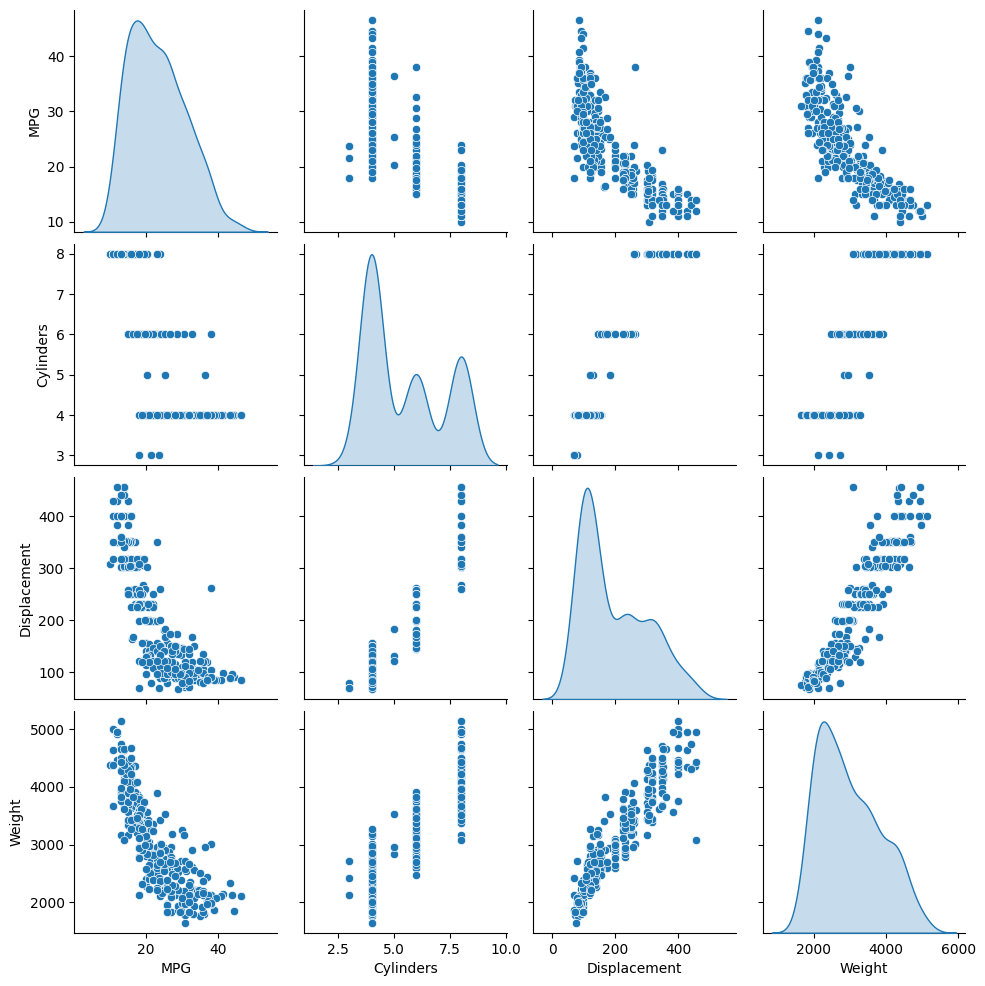

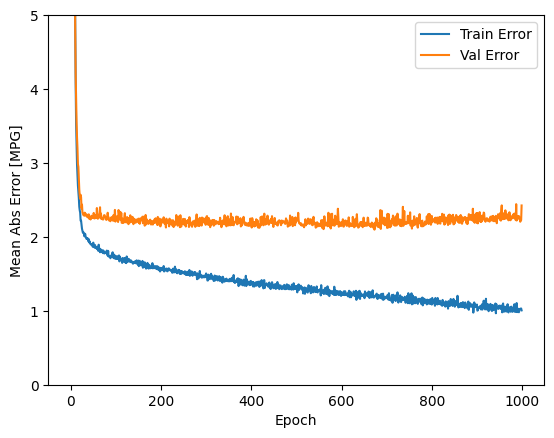

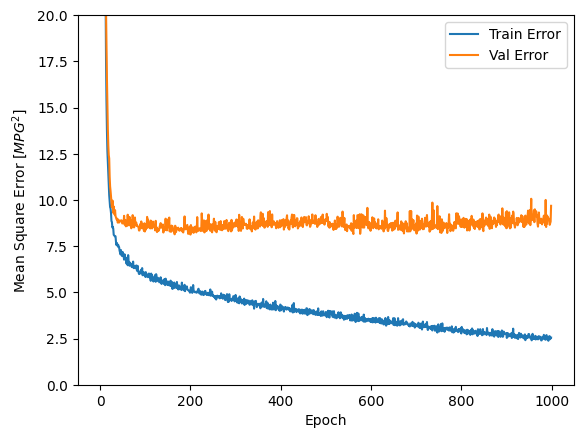

In [24]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

该图表显示在约100个 epochs 之后误差非但没有改进，反而出现恶化。 让我们更新 model.fit 调用，当验证值没有提高上是自动停止训练。 **我们将使用一个 _EarlyStopping callback_ 来测试每个 epoch 的训练条件。如果经过一定数量的 epochs 后没有改进，则自动停止训练。**

你可以从[**这里**](https://tensorflow.google.cn/versions/master/api_docs/python/tf/keras/callbacks/EarlyStopping)学习到更多的回调。


...................................................................

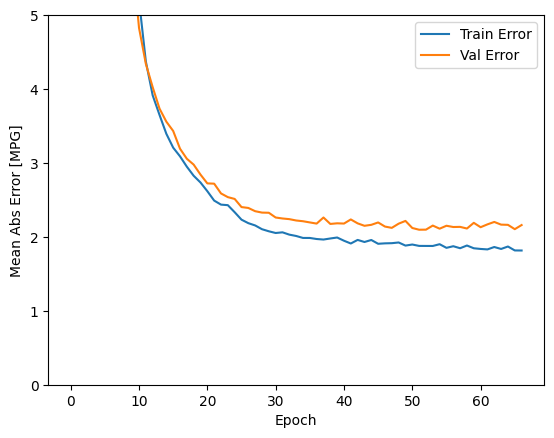

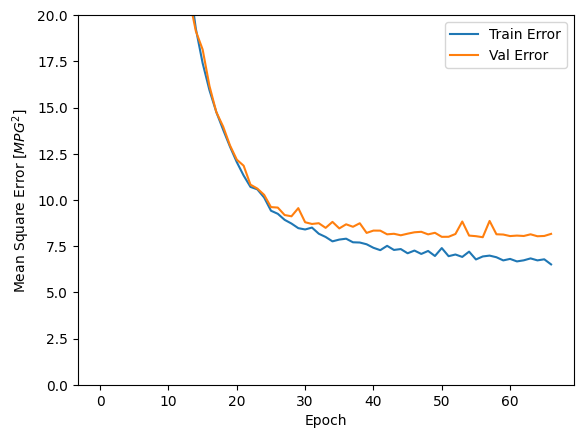

In [25]:
model = build_model()

# patience 值用来检查改进 epochs 的数量
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

如图所示，验证集中的平均的误差通常在 +/- 2 MPG左右。 这个结果好么？ 我们将决定权留给你。

让我们看看通过使用 **测试集** 来泛化模型的效果如何，我们在训练模型时没有使用测试集。这告诉我们，当我们在现实世界中使用这个模型时，我们可以期望它预测得有多好。

In [26]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 5.3746 - mae: 1.7559 - mse: 5.3746 - 16ms/epoch - 5ms/step
Testing set Mean Abs Error:  1.76 MPG


## 做预测
最后，使用测试集中的数据预测 MPG 值:

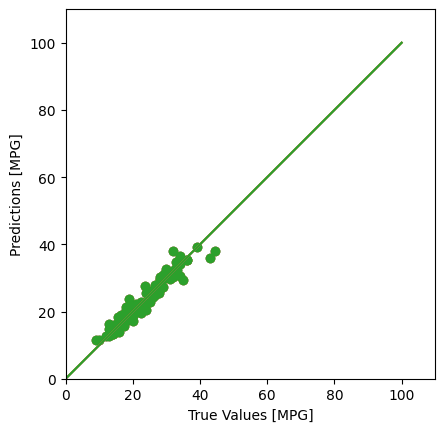

In [30]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])
# 展示图
plt.show()

这看起来我们的模型预测得相当好。我们来看下误差分布。

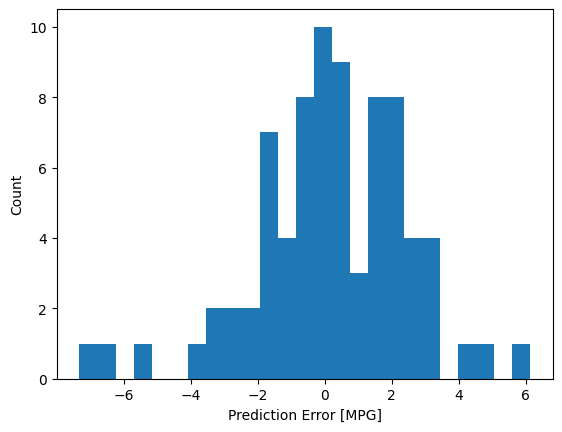

In [34]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")
plt.show()

它不是完全的高斯分布，但我们可以推断出，这是因为样本的数量很小所导致的。

# 结论
本笔记本 (notebook) 介绍了一些处理回归问题的技术。

- 均方误差（MSE）是用于回归问题的常见损失函数（分类问题中使用不同的损失函数）。
- 类似的，用于回归的评估指标与分类不同。 常见的回归指标是平均绝对误差（MAE）。
- 当数字输入数据特征的值存在不同范围时，每个特征应独立缩放到相同范围。
- 如果训练数据不多，一种方法是选择隐藏层较少的小网络，以避免过度拟合。
- 早期停止是一种防止过度拟合的有效技术。